In [1]:
# Customer Segmantation with K-Means 

# İş Problemi : RFM metriklerine göre (skorlar değil) K-Means'i kullanarak müşteri segmentasyonu yapınız.

# VERİ SETİ HİKAYESİ 
# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının 
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içermektedir. Bu şirketin ürün 
# kataloğunda hediyelik eşyalar yer almaktadır.Şirketin müşterilerinin büyük çoğunluğu kurumsal 
# müşterilerdir.

# DEĞİŞKENLER

# InvoiceNo : Fatura Numarası ('Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder.')
# StockCode : Ürün kodu ('Her bir ürün için eşsiz numara.')
# Description : Ürün ismi
# Quantity : Ürün adedi ('Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.')
# InvoiceDate : Fatura tarihi
# UnitPrice : Fatura fiyatı (Sterlin)
# CustomerID : Eşsiz müşteri numarası
# Country : Ülke ismi

In [2]:
# ilgili kütüphaneler

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
df_ = pd.read_csv("../input/online-retail-ii-data-set-from-ml-repository/Year 2010-2011.csv", sep=",", encoding="ISO-8859-1", header=0)

In [4]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541910, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [8]:
# DATA PRE-PROCESSING

df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [11]:
df = df[~df["Invoice"].str.contains("C", na=False)]

In [12]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [13]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [14]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [16]:
today_date = dt.datetime(2011, 12, 11)
rfm_df = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [17]:
rfm_df.columns = ['recency', 'frequency', 'monetary']
rfm_df = rfm_df[(rfm_df['monetary'] > 0)]
rfm_df.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,326,1,310.44
12347.0,3,7,4310.00
12348.0,76,4,1770.78
12349.0,19,1,1491.72
12350.0,311,1,331.46


In [18]:
# we keep for K-Means

km_df = rfm_df.copy()
km_df.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,326,1,310.44
12347.0,3,7,4310.00
12348.0,76,4,1770.78
12349.0,19,1,1491.72
12350.0,311,1,331.46


In [19]:
rfm_df["recency_score"] = pd.qcut(rfm_df["recency"], 5, labels=[5, 4, 3, 2, 1])

rfm_df["frequency_score"] = pd.qcut(rfm_df["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm_df["monetary_score"] = pd.qcut(rfm_df["monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm_df["RFM_SCORE"] = (rfm_df['recency_score'].astype(str) +
                    rfm_df['frequency_score'].astype(str))

rfm_df.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,326,1,310.44,1,1,2,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1770.78,2,4,4,24
12349.0,19,1,1491.72,4,1,4,41
12350.0,311,1,331.46,1,1,2,11


In [20]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm_df["SEGMENT"] = rfm_df["RFM_SCORE"].replace(seg_map, regex=True)
rfm_df.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,SEGMENT
Customer ID,,,,,,,,
12346.0,326,1,310.44,1,1,2,11,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions
12348.0,76,4,1770.78,2,4,4,24,at_Risk
12349.0,19,1,1491.72,4,1,4,41,promising
12350.0,311,1,331.46,1,1,2,11,hibernating


In [21]:
# scaler for K-Means

sc = MinMaxScaler((0, 1))
km_df = sc.fit_transform(km_df)

In [22]:
km_df = pd.DataFrame(km_df)
km_df.columns = ['Recency', 'Frequency', 'Monetary']
km_df.head()

,Recency,Frequency,Monetary
0,0.871314,0.000000,0.001152
1,0.005362,0.028846,0.016179
2,0.201072,0.014423,0.006639
3,0.048257,0.000000,0.005591
4,0.831099,0.000000,0.001231


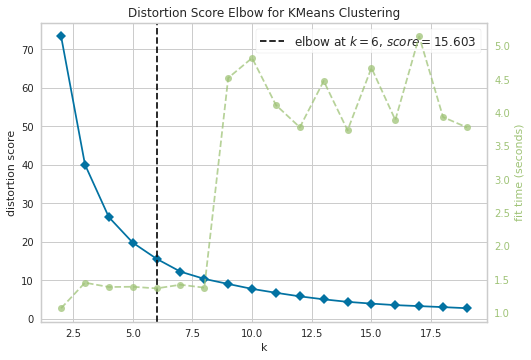

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# optimum number of cluster 

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(km_df)
elbow.show()

In [24]:
elbow.elbow_value_

6

In [25]:
# final cluster

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(km_df)
clusters = kmeans.labels_

km_df["cluster_no"] = clusters

km_df["cluster_no"] = km_df["cluster_no"] + 1

km_df.head()

,Recency,Frequency,Monetary,cluster_no
0,0.871314,0.000000,0.001152,5
1,0.005362,0.028846,0.016179,1
2,0.201072,0.014423,0.006639,4
3,0.048257,0.000000,0.005591,1
4,0.831099,0.000000,0.001231,5


In [26]:
km_df.reset_index(inplace=True)

In [27]:
rfm_df.reset_index(inplace=True)

In [28]:
rfm_df.reset_index(inplace=True)

In [29]:
km_rfm = rfm_df.merge(km_df, on="index", how="left")
km_rfm = km_rfm.drop(["Recency", "Frequency", "Monetary"],axis=1)
km_rfm.head()

,index,Customer ID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,SEGMENT,cluster_no
0,0,12346.0,326,1,310.44,1,1,2,11,hibernating,5
1,1,12347.0,3,7,4310.00,5,5,5,55,champions,1
2,2,12348.0,76,4,1770.78,2,4,4,24,at_Risk,4
3,3,12349.0,19,1,1491.72,4,1,4,41,promising,1
4,4,12350.0,311,1,331.46,1,1,2,11,hibernating,5


In [30]:
dummy_df = km_rfm["cluster_no"]
dummy_df = pd.get_dummies(dummy_df)
dummy_df = dummy_df.reset_index()
km_rfm = pd.concat([km_rfm, dummy_df], axis=1)

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [32]:
km_rfm.groupby("SEGMENT").agg({ 1 : "sum",
                                2 : "sum",
                                3 : "sum",
                                4 : "sum",
                                5 : "sum",
                                6 : "sum"})

,1,2,3,4,5,6
SEGMENT,,,,,,
about_to_sleep,109,0,0,243,0,0
at_Risk,0,92,231,240,30,0
cant_loose,0,5,19,36,3,0
champions,613,0,0,0,0,20
hibernating,0,329,266,220,256,0
loyal_customers,650,0,0,166,0,3
need_attention,76,0,0,111,0,0
new_customers,42,0,0,0,0,0
potential_loyalists,484,0,0,0,0,0


In [33]:
# Buradan elde edeceğimiz sonuç bize hangi kümelerde hangi segmentlere göre aksiyon alınacağını 
# gösterecektir. 1.kümede sadece champions için aksiyon alınabilir. 5.kümede aksiyon ağırlığı 
# champions ve loyal_customer segmentindekilere verilebilir şeklinde yorumlar yaparak hangi kümelerde 
# hangi segmentlere ağırlık verileceğine karar verilebilir.